/root/anaconda3/envs/test-complex/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/root/anaconda3/envs/test-complex/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


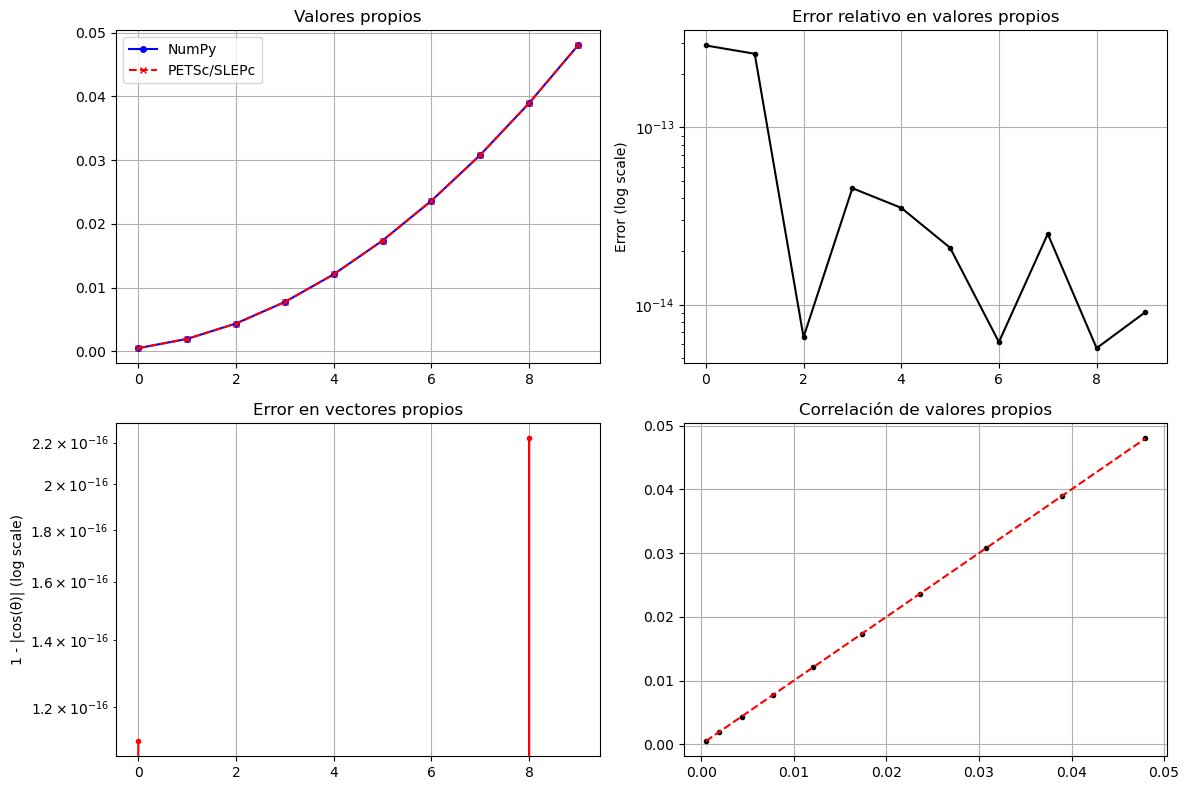


Estadísticas de error:
Error máximo en valores propios: 2.89e-13
Error máximo en vectores propios: 2.22e-16
Error medio en vectores propios: -7.77e-17


In [1]:
from eigenvalue_solver import solve_generalized_eigenvalue_problem

import numpy as np
from petsc4py import PETSc
from scipy import sparse
import matplotlib.pyplot as plt

def create_test_matrices(n=100):
    """
    Crea matrices de prueba mejoradas para mejor precisión
    """
    # Crear matriz A (tridiagonal simétrica)
    diagonal = 2 * np.ones(n)
    upper_diag = -1 * np.ones(n-1)
    lower_diag = -1 * np.ones(n-1)
    A = sparse.diags([diagonal, upper_diag, lower_diag], [0, 1, -1]).toarray()
    
    # Crear matriz B (definida positiva)
    B = sparse.diags([2 * np.ones(n)], [0]).toarray()
    
    # Asegurar simetría perfecta
    A = (A + A.T) / 2
    B = (B + B.T) / 2
    
    return A, B

def normalize_eigenvector(v):
    """
    Normaliza el vector propio y asegura una fase consistente
    """
    # Normalización con respecto a la norma-2
    v = v / np.linalg.norm(v)
    
    # Hacer que el componente más grande sea positivo
    max_idx = np.argmax(np.abs(v))
    if v[max_idx] < 0:
        v = -v
    
    return v

def convert_to_petsc(A, B):
    """
    Convierte matrices NumPy a formato PETSc con mayor precisión
    """
    n = A.shape[0]
    A_petsc = PETSc.Mat().createDense([n, n])
    B_petsc = PETSc.Mat().createDense([n, n])
    
    # Configurar para mayor precisión
    A_petsc.setOption(PETSc.Mat.Option.NEW_NONZERO_ALLOCATION_ERR, False)
    B_petsc.setOption(PETSc.Mat.Option.NEW_NONZERO_ALLOCATION_ERR, False)
    
    A_petsc.setValues(range(n), range(n), A)
    B_petsc.setValues(range(n), range(n), B)
    
    A_petsc.assemble()
    B_petsc.assemble()
    
    return A_petsc, B_petsc

def compare_eigensolvers(n=100, nev=10):
    """
    Compara los resultados entre NumPy y PETSc/SLEPc con precisión mejorada
    """
    # Crear matrices de prueba
    A, B = create_test_matrices(n)
    
    # Resolver usando NumPy con scipy.linalg para mayor precisión
    from scipy import linalg
    eigenvals_np, eigenvecs_np = linalg.eigh(A, B)
    
    # Ordenar y normalizar
    idx = np.argsort(eigenvals_np)
    eigenvals_np = eigenvals_np[idx]
    eigenvecs_np = eigenvecs_np[:, idx]
    
    # Normalizar vectores propios de NumPy
    for i in range(eigenvecs_np.shape[1]):
        eigenvecs_np[:, i] = normalize_eigenvector(eigenvecs_np[:, i])
    
    # Tomar solo los primeros nev valores
    eigenvals_np = eigenvals_np[:nev]
    eigenvecs_np = eigenvecs_np[:, :nev].T
    
    # Convertir a formato PETSc
    A_petsc, B_petsc = convert_to_petsc(A, B)
    
    # Configurar y resolver usando PETSc/SLEPc con mayor precisión
    eigenvals_petsc, eigenvecs_petsc = solve_generalized_eigenvalue_problem(
        A_petsc, B_petsc, 
        nev=nev,
        tol=1e-30,  # Aumentar precisión
        max_it=2000  # Aumentar iteraciones máximas
    )
    
    # Normalizar vectores propios de PETSc
    for i in range(nev):
        eigenvecs_petsc[i] = normalize_eigenvector(eigenvecs_petsc[i])
    
    # Calcular errores con métrica mejorada
    eigenval_error = np.abs(eigenvals_np - eigenvals_petsc) / np.abs(eigenvals_np)
    
    # Calcular error en vectores propios usando producto interno
    eigenvec_error = []
    for i in range(nev):
        # Calcular el producto interno entre los vectores
        dot_product = np.abs(np.dot(eigenvecs_np[i], eigenvecs_petsc[i]))
        error = 1 - dot_product  # Error basado en el coseno del ángulo entre vectores
        eigenvec_error.append(error)
    
    return eigenvals_np, eigenvals_petsc, eigenval_error, eigenvec_error

def plot_comparison(eigenvals_np, eigenvals_petsc, eigenval_error, eigenvec_error):
    """
    Visualiza la comparación con más detalles
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
    
    # Valores propios
    ax1.plot(eigenvals_np, 'bo-', label='NumPy', markersize=4)
    ax1.plot(eigenvals_petsc, 'rx--', label='PETSc/SLEPc', markersize=4)
    ax1.set_title('Valores propios')
    ax1.legend()
    ax1.grid(True)
    
    # Error en valores propios
    ax2.semilogy(eigenval_error, 'k.-', label='Error relativo')
    ax2.set_title('Error relativo en valores propios')
    ax2.grid(True)
    ax2.set_ylabel('Error (log scale)')
    
    # Error en vectores propios
    ax3.semilogy(eigenvec_error, 'r.-', label='Error angular')
    ax3.set_title('Error en vectores propios')
    ax3.grid(True)
    ax3.set_ylabel('1 - |cos(θ)| (log scale)')
    
    # Correlación
    ax4.plot(eigenvals_np, eigenvals_petsc, 'k.')
    ideal = np.linspace(min(eigenvals_np), max(eigenvals_np), 100)
    ax4.plot(ideal, ideal, 'r--', label='Ideal')
    ax4.set_title('Correlación de valores propios')
    ax4.grid(True)
    
    plt.tight_layout()
    return fig

# Ejecutar la prueba
if __name__ == "__main__":
    eigenvals_np, eigenvals_petsc, eigenval_error, eigenvec_error = compare_eigensolvers()
    fig = plot_comparison(eigenvals_np, eigenvals_petsc, eigenval_error, eigenvec_error)
    plt.show()
    
    print("\nEstadísticas de error:")
    print(f"Error máximo en valores propios: {np.max(eigenval_error):.2e}")
    print(f"Error máximo en vectores propios: {np.max(eigenvec_error):.2e}")
    print(f"Error medio en vectores propios: {np.mean(eigenvec_error):.2e}")